In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import defaultdict
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)

import google.cloud.bigquery as bq
client = bq.Client.from_service_account_json("marius_arlauskas.json")

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
query = """SELECT * FROM `surfshark-analytics.temp_linas.attribution_test_v2`"""

In [3]:
def get_data(sql_query):

    # Make an API request.
    query_job = client.query(sql_query)

    # Convert as dataframe
    dataframe = (
        query_job
        .result()
        .to_dataframe()
    )
    return dataframe

#df = get_data(query)
df = pd.read_csv('real.csv')

In [4]:
new_df = pd.DataFrame()
new_df['cookie'] = df['clientId']
new_df['conversion'] = df['transactionRevenue'].notna()*1
new_df['conversion_value'] = df['transactionRevenue'].fillna(0)
new_df['time'] = df['visit_started_at']
new_df['channel'] = df['channel']
new_df['sourceMedium'] = df['sourceMedium']
new_df['subchannel'] = df['subchannel']

df = new_df
df.head(3)

,cookie,conversion,conversion_value,time,channel,sourceMedium,subchannel
0,2001330320.166,1,60.740,2022-08-16 17:45:00+00:00,ppc,fb / ads,ppc_facebook
1,2039680610.166,1,58.050,2022-08-18 07:48:05+00:00,ppc,fb / ads,ppc_facebook
2,1204934934.166,1,55.910,2022-08-27 23:39:24+00:00,affiliates_nonvps,a8 / 5857,affiliates_nonvps_a8


In [5]:
df.isna().sum()/len(df)

cookie             0.000
conversion         0.000
conversion_value   0.000
time               0.000
channel            0.004
sourceMedium       0.000
subchannel         0.000
dtype: float64

In [6]:
df.dropna(inplace=True)

In [7]:
df = df.sort_values(['cookie', 'time'], ascending=[False, True])
df['visit_order'] = df.groupby('cookie').cumcount() + 1

In [8]:
df_paths = df.groupby('cookie')[['channel', 'time']].aggregate(lambda x: x.tolist()).reset_index()

In [9]:
df_paths['conversion'] = df.drop_duplicates(subset=['cookie'], keep='last').set_index('cookie', drop=True)['conversion'][df_paths['cookie']].values
df_paths['conversion_value'] = df.drop_duplicates(subset=['cookie'], keep='last').set_index('cookie', drop=True)['conversion_value'][df_paths['cookie']].values

In [10]:
def get_journey_len(x):
    first = x[0]
    last = x[-1]
    first = datetime.strptime(first.split('+')[0], "%Y-%m-%d %H:%M:%S")
    last = datetime.strptime(last.split('+')[0], "%Y-%m-%d %H:%M:%S")
    return (last - first).total_seconds() / 3600

def time_in_between(x):
    rez = [np.nan]
    for i in range(len(x) - 1):
        first = x[i]
        last = x[i+1]
        first = datetime.strptime(first.split('+')[0], "%Y-%m-%d %H:%M:%S")
        last = datetime.strptime(last.split('+')[0], "%Y-%m-%d %H:%M:%S")
        rez.append((last - first).total_seconds())
    return np.array(rez) / 3600

def time_from(x):
    rez = []
    for i in range(len(x)):
        first = x[i]
        last = x[-1]
        first = datetime.strptime(first.split('+')[0], "%Y-%m-%d %H:%M:%S")
        last = datetime.strptime(last.split('+')[0], "%Y-%m-%d %H:%M:%S")
        rez.append((last - first).total_seconds())
    return np.array(rez) / 3600

In [11]:
df_paths['journey_full_time']  = df_paths['time'].apply(get_journey_len)
df_paths['in_between_sessions'] = df_paths['time'].apply(time_in_between)
df_paths['journey_len'] = df_paths['channel'].apply(len)
df_paths['avg_time_in_between'] = df_paths['in_between_sessions'].apply(np.nanmean)
df_paths['n_unique_chn'] = df_paths['channel'].apply(set)
df_paths['n_unique_chn'] = df_paths['n_unique_chn'].apply(len)

In [12]:
df_paths.describe()

,cookie,conversion,conversion_value,journey_full_time,journey_len,avg_time_in_between,n_unique_chn
count,3007272.000,3007272.000,3007272.000,3007272.000,3007272.000,802944.000,3007272.000
mean,1073435482.980,0.025,1.284,189.009,1.875,278.874,1.147
std,620159821.778,0.156,8.746,747.849,5.887,623.720,0.449
min,40.166,0.000,0.000,0.000,1.000,0.000,1.000
25%,535890032.166,0.000,0.000,0.000,1.000,1.403,1.000
50%,1073271461.666,0.000,0.000,0.000,1.000,34.004,1.000
75%,1610922444.416,0.000,0.000,0.021,2.000,267.656,1.000
max,2147483117.166,1.000,120.990,6544.477,1838.000,5803.151,8.000


In [13]:
df_paths[df_paths['conversion']==1].describe()

,cookie,conversion,conversion_value,journey_full_time,journey_len,avg_time_in_between,n_unique_chn
count,75257.000,75257.000,75257.000,75257.000,75257.000,33569.000,75257.000
mean,1071660435.963,1.000,51.295,100.617,2.126,98.626,1.374
std,620172297.489,0.000,22.160,462.130,2.795,364.349,0.682
min,25646.166,1.000,0.030,0.000,1.000,0.000,1.000
25%,535423636.166,1.000,47.880,0.000,1.000,0.086,1.000
50%,1072433464.166,1.000,56.490,0.000,1.000,1.709,1.000
75%,1608213425.166,1.000,59.760,1.183,2.000,32.224,2.000
max,2147482217.166,1.000,120.990,5706.192,241.000,5644.937,8.000


In [14]:
df_paths[df_paths['conversion']==0].describe()

,cookie,conversion,conversion_value,journey_full_time,journey_len,avg_time_in_between,n_unique_chn
count,2932015.000,2932015.000,2932015.000,2932015.000,2932015.000,769375.000,2932015.000
mean,1073481043.702,0.000,0.000,191.278,1.869,286.739,1.141
std,620159540.441,0.000,0.000,753.622,5.945,631.450,0.440
min,40.166,0.000,0.000,0.000,1.000,0.000,1.000
25%,535900132.666,0.000,0.000,0.000,1.000,1.676,1.000
50%,1073290660.166,0.000,0.000,0.000,1.000,37.688,1.000
75%,1610989037.666,0.000,0.000,0.014,2.000,285.250,1.000
max,2147483117.166,0.000,0.000,6544.477,1838.000,5803.151,8.000


<AxesSubplot:xlabel='journey_full_time', ylabel='journey_len'>

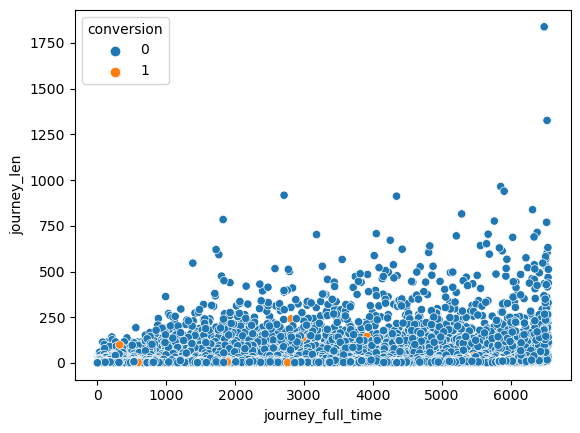

In [15]:
sns.scatterplot(x=df_paths['journey_full_time'], y=df_paths['journey_len'], hue=df_paths['conversion'])

In [16]:
df_paths = df_paths[df_paths['journey_len'] < 250]

<AxesSubplot:xlabel='journey_full_time', ylabel='journey_len'>

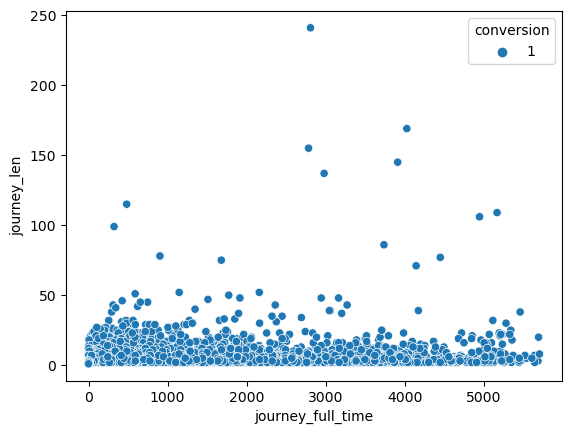

In [17]:
df_draw =  df_paths[df_paths['conversion'] == 1]
sns.scatterplot(x=df_draw['journey_full_time'], y=df_draw['journey_len'], hue=df_draw['conversion'])

<AxesSubplot:xlabel='journey_full_time', ylabel='journey_len'>

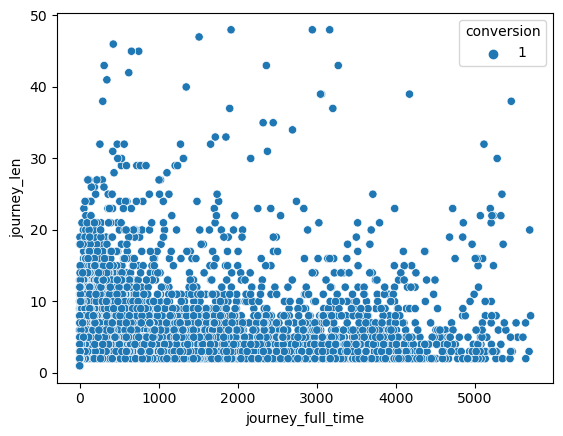

In [18]:
df_paths = df_paths[df_paths['journey_len'] < 50]
df_draw =  df_paths[df_paths['conversion'] == 1]
sns.scatterplot(x=df_draw['journey_full_time'], y=df_draw['journey_len'], hue=df_draw['conversion'])

In [19]:
df_paths = df_paths[df_paths['journey_len'] < 20]
df_paths = df_paths[df_paths['journey_full_time'] < 24*14]

In [20]:
df_paths[df_paths['conversion'] == 1].describe()

,cookie,conversion,conversion_value,journey_full_time,journey_len,avg_time_in_between,n_unique_chn
count,70756.000,70756.000,70756.000,70756.000,70756.000,29068.000,70756.000
mean,1072826510.623,1.000,51.257,12.769,1.875,15.612,1.330
std,620354091.194,0.000,22.303,43.273,1.570,37.397,0.631
min,25646.166,1.000,0.030,0.000,1.000,0.000,1.000
25%,536818919.166,1.000,47.880,0.000,1.000,0.065,1.000
50%,1073928853.166,1.000,56.500,0.000,1.000,0.759,1.000
75%,1610160025.416,1.000,59.760,0.364,2.000,12.274,2.000
max,2147482217.166,1.000,120.990,335.994,19.000,335.579,7.000


In [21]:
df_paths[df_paths['conversion'] == 0].describe()

,cookie,conversion,conversion_value,journey_full_time,journey_len,avg_time_in_between,n_unique_chn
count,2661883.000,2661883.000,2661883.000,2661883.000,2661883.000,499243.000,2661883.000
mean,1073359873.853,0.000,0.000,9.474,1.340,30.285,1.082
std,620144777.899,0.000,0.000,39.122,1.010,54.589,0.315
min,40.166,0.000,0.000,0.000,1.000,0.000,1.000
25%,535809890.166,0.000,0.000,0.000,1.000,0.249,1.000
50%,1073147617.166,0.000,0.000,0.000,1.000,6.234,1.000
75%,1610841065.166,0.000,0.000,0.000,1.000,35.726,1.000
max,2147483117.166,0.000,0.000,335.998,19.000,335.995,7.000


In [22]:
df_paths

,cookie,channel,time,conversion,conversion_value,journey_full_time,in_between_sessions,journey_len,avg_time_in_between,n_unique_chn
0,40.166,[brand],[2022-08-30 15:59:00+00:00],0,0.000,0.000,[nan],1,NaN,1
1,1585.166,[organic],[2022-08-26 12:19:15+00:00],0,0.000,0.000,[nan],1,NaN,1
2,1701.166,[organic],[2022-08-04 08:08:52+00:00],0,0.000,0.000,[nan],1,NaN,1
3,2560.166,[affiliates_vps],[2022-08-18 08:06:31+00:00],0,0.000,0.000,[nan],1,NaN,1
4,2749.166,[ppc],[2022-08-17 05:33:07+00:00],0,0.000,0.000,[nan],1,NaN,1
...,...,...,...,...,...,...,...,...,...,...
3007266,2147481064.166,[organic],[2022-08-09 18:22:35+00:00],0,0.000,0.000,[nan],1,NaN,1
3007267,2147481070.166,[brand],[2022-08-05 23:01:50+00:00],0,0.000,0.000,[nan],1,NaN,1
3007269,2147482217.166,[organic],[2022-08-28 05:34:50+00:00],1,59.760,0.000,[nan],1,NaN,1
3007270,2147482730.166,"[other, other, other, other]","[2022-08-31 17:12:27+00:00, 2022-09-01 20:10:5...",0,0.000,111.940,"[nan, 26.975555555555555, 81.73333333333333, 3...",4,37.313,1


In [25]:
def prune_sessions_s(times, sessions):
    times = list(times)
    sessions = list(sessions)
    new_t = []
    new_s = []
    for i in range(len(sessions)):
        if times[i] < 0.5:
            try:
                times[i+1] += times[i]
            except IndexError:
                new_t.append(times[i])
                new_s.append(sessions[i])
        else:
            new_t.append(times[i])
            new_s.append(sessions[i])
    return new_s


In [26]:
df_paths['fixed_sessions'] = df_paths.apply(lambda x: prune_sessions_s(x['in_between_sessions'], x['channel']), axis=1)
df_paths['fixed_times'] = df_paths.apply(lambda x: prune_sessions_s(x['in_between_sessions'], x['time']), axis=1)

In [27]:
df_paths[df_paths['channel'] != df_paths['fixed_sessions']][['channel', 'fixed_sessions', 'in_between_sessions', 'fixed_times']]

,channel,fixed_sessions,in_between_sessions,fixed_times
97,"[ppc, ppc, ppc, ppc, affiliates_vps]","[ppc, affiliates_vps]","[nan, 0.03888888888888889, 0.0425, 0.194722222...","[2022-08-08 15:31:56+00:00, 2022-08-08 15:56:5..."
105,"[affiliates_nonvps, brand, organic, organic]","[affiliates_nonvps, organic]","[nan, 0.07027777777777777, 0.0175, 1.142777777...","[2022-08-15 05:33:27+00:00, 2022-08-15 06:47:1..."
184,"[affiliates_nonvps, affiliates_nonvps, webutat...","[affiliates_nonvps, organic, webutation, webut...","[nan, 0.12444444444444444, 0.04444444444444444...","[2022-08-09 10:16:31+00:00, 2022-08-09 11:03:3..."
196,"[affiliates_nonvps, affiliates_nonvps, affilia...","[affiliates_nonvps, affiliates_nonvps, affilia...","[nan, 0.1361111111111111, 2.602222222222222, 1...","[2022-08-16 02:45:16+00:00, 2022-08-16 05:29:3..."
249,"[brand, ppc, brand, brand]","[brand, brand]","[nan, 0.08722222222222223, 0.3516666666666667,...","[2022-08-11 10:10:50+00:00, 2022-08-11 13:20:0..."
...,...,...,...,...
3007029,"[organic, brand, brand, affiliates_nonvps]","[organic, brand, affiliates_nonvps]","[nan, 0.06805555555555555, 24.924722222222222,...","[2022-08-22 00:17:16+00:00, 2022-08-23 01:16:5..."
3007087,"[organic, organic, organic]","[organic, organic]","[nan, 0.01361111111111111, 0.0575]","[2022-08-12 12:33:54+00:00, 2022-08-12 12:38:1..."
3007200,"[brand, brand, brand, brand, brand]","[brand, brand, brand]","[nan, 0.08638888888888889, 0.09333333333333334...","[2022-07-31 07:14:12+00:00, 2022-08-02 02:06:5..."
3007238,"[brand, brand, organic]","[brand, organic]","[nan, 0.015555555555555555, 0.44222222222222224]","[2022-08-05 18:50:42+00:00, 2022-08-05 19:18:1..."


In [35]:
new_df = df_paths[['cookie', 'fixed_sessions', 'fixed_times', 'conversion_value', 'conversion']]

In [36]:
new_df.to_csv('cleaned_df.csv')